In [1]:
# Calculations to create a histogram of all the e- densities that are defined as SpE layers in the algorithm
# Used to identify the lower limit of e densities that cause SpEs
# Also work out the critical frequencies that cause layers

In [7]:
import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
#from cftime import datetime 
from datetime import datetime, timedelta
#import datetime as dt
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator
#jet = mcm.get_cmap('jet')
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')
import netCDF4 as nc
import sys
import os
import psutil
import netCDF4 as nc
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
from tqdm import tqdm
from dask.distributed import LocalCluster, Client
import dask.array as da
import dask.dataframe as dd
import dask
from dask import delayed
from dask.diagnostics import ProgressBar  # Import the ProgressBar class
import calendar
import glob
%matplotlib inline 
#import line_profiler
#%load_ext line_profiler

/tmp/ipykernel_3288788/1870643686.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


# Mptdens Min & Max Values

In [ ]:
# to get rough boundaries for the histogram

In [2]:
fp1 = 'Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-*.nc'
ds = xr.open_mfdataset(fp1)
#ds



timee = ds.variables['time']

lon = ds.variables['lon']
lat = ds.variables['lat']
lev = ds.variables['lev']
dst = ds.transpose("lev", ...)
#geopH = dst.variables['Z3'] / 1000 #m-> km    #(126, 744, 96, 144)        #Mpt = dst.variables['Fep'] 

temp = dst.variables['T']

Fept = dst.variables['Fep']
Mgpt = dst.variables['Mgp']
Napt = dst.variables['Nap']


lev_sl_idx_min = 41      
lev_sl_idx_max = 60 

lev_sl = lev[lev_sl_idx_min:lev_sl_idx_max+1]

tempe = temp[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]

Fep_t = Fept[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]
Mgp_t = Mgpt[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]
Nap_t = Napt[lev_sl_idx_min:lev_sl_idx_max+1,:,:,:]


Feptdens = ( Fep_t * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)
Mgptdens = ( Mgp_t * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)
Naptdens = ( Nap_t * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)
            
Mptdens = Feptdens + (2 * Mgptdens ) + Naptdens    # equivalent to [Fep] * Factor where Factor = (Fep+2Mgp+Nap)/Fep



In [10]:
min_values = np.min(Mptdens, axis=(0, 1, 2, 3))
max_values = np.max(Mptdens, axis=(0, 1, 2, 3))

min_value = np.min(min_values)
print(f'Mptdens min = {min_value.values}')   

max_value = np.max(max_values)
print(f'Mptdens max = {max_value.values}')  


#All year
#Mptdens min = 9.222161535569176e-06
#Mptdens max = 3563445.6983512472

Mptdens min = 9.222161535569176e-06
Mptdens max = 3563445.6983512472


# Bin Definitions

In [8]:

bin_edges = np.logspace(np.log10(5e2), np.log10(5e6), 101)

bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)
num_bins = len(bin_midpoints)

# # Print the results
# print("Bin Edges (Lower and Upper):")
# for i in range(len(bin_edges) - 1):
#     print(f"Bin {i + 1}: [{bin_edges[i]}, {bin_edges[i + 1]}]")

# print("\nBin Midpoints:")
# for i in range(len(bin_midpoints)):
#     print(f"Bin {i + 1} Midpoint: {bin_midpoints[i]}")

# print("\nBin Widths:", bin_widths)
print(f"Number of Bins: {num_bins}")

Number of Bins: 100


# Histogram calcs

In [ ]:

seasons = [ #'Dec-Feb', 
'Mar-May', 'Jun-Aug', 'Sep-Nov' ]

for season in seasons:
    
    testds = xr.open_dataset(f'Nc_Files/SpE_Output/Wuhu_IonTr_run_SpE_Output_{season}.nc')
    SpEsns = testds['SpEsns']   #'lev_sl', 'time', 'lat', 'lon', 'timesl', 'mth'  (20,336,96,144,2,3)
    flattened_SpEsns = SpEsns.values.flatten()

    # Initialize an array to store histogram counts for each bin
    histogram_counts = np.zeros(len(bin_edges) - 1)


    for value in tqdm(flattened_SpEsns):
        if np.isnan(value):
            continue

        # Find the bin index for the value
        bin_index = np.digitize(value, bin_edges, right=True)

        # Increment the corresponding bin in the histogram
        histogram_counts[bin_index - 1] += 1
        
        
    output_nc_file = f'./Nc_Files/e_histogram/{season}_e_histogram_data.nc'
    with nc.Dataset(output_nc_file, 'w') as dataset:
        # Create dimensions
        dataset.createDimension('num_bins', num_bins)
        dataset.createDimension('bin_edges', num_bins+1)

        # Create variables
        bin_edges_var = dataset.createVariable('bin_edges', 'f8', ('bin_edges',))
        bin_midpoints_var = dataset.createVariable('bin_midpoints', 'f8', ('num_bins',))
        bin_widths_var = dataset.createVariable('bin_widths', 'f8', ('num_bins',))
        histogram_counts_var = dataset.createVariable('histogram_counts', 'i4', ('num_bins',))

        # Assign values to variables
        bin_edges_var[:] = bin_edges
        bin_midpoints_var[:] = bin_midpoints
        bin_widths_var[:] = bin_widths
        histogram_counts_var[:] = histogram_counts

    print(f"Histogram data saved to {output_nc_file}")


# Load data and Plot

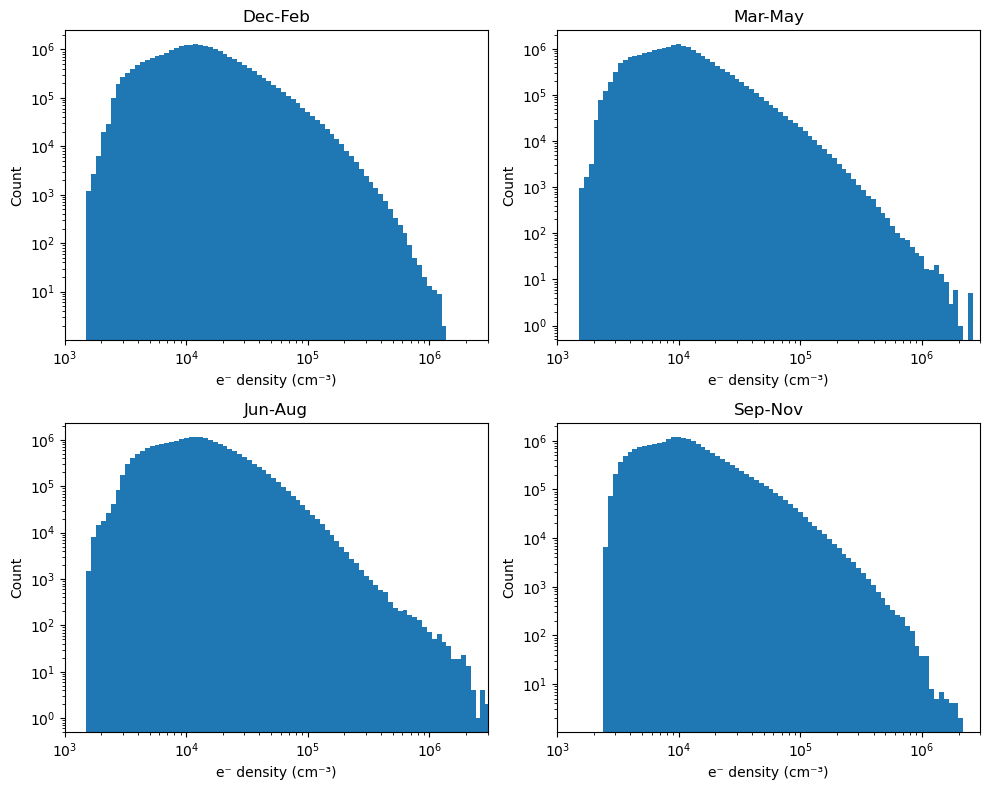

In [12]:

# Load data for each season
resultds_win = xr.open_dataset(f'Nc_Files/e_histogram/Dec-Feb_e_histogram_data.nc')
counts_win = resultds_win['histogram_counts']

resultds_spr = xr.open_dataset(f'Nc_Files/e_histogram/Mar-May_e_histogram_data.nc')
counts_spr = resultds_spr['histogram_counts']

resultds_sum = xr.open_dataset(f'Nc_Files/e_histogram/Jun-Aug_e_histogram_data.nc')
counts_sum = resultds_sum['histogram_counts']

resultds_aut = xr.open_dataset(f'Nc_Files/e_histogram/Sep-Nov_e_histogram_data.nc')
counts_aut = resultds_aut['histogram_counts']

# List of seasons
seasons = ['Dec-Feb', 'Mar-May', 'Jun-Aug', 'Sep-Nov']

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Organize the data for easy iteration
data_for_each_season = [counts_win, counts_spr, counts_sum, counts_aut]

# Iterate over seasons and plot histogram in each subplot
for i, (season, counts) in enumerate(zip(seasons, data_for_each_season)):
    # Choose the appropriate subplot
    ax = axes[i // 2, i % 2]

    # Plot histogram
    bin_edges = resultds_win['bin_edges']  # Assuming bin_edges are the same for all seasons
    ax.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge', log=True)

    # Set labels and title
    ax.set_xlabel('e\u207B density (cm\u207B\u00B3)'
)
    ax.set_ylabel('Count')
    ax.set_title(f'{season}')
    ax.set_xscale('log')
    ax.set_xlim(1e3, 3e6)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
# Organize the data for easy iteration
data_for_each_season = [counts_win, counts_spr, counts_sum, counts_aut]

# Iterate over seasons and print the lower and upper bin edges with non-zero counts
for season, counts in zip(seasons, data_for_each_season):
    non_zero_indices = np.nonzero(counts.values.ravel())[0]
    
    if non_zero_indices.size > 0:
        # Find the first and last non-zero indices
        first_non_zero_index = non_zero_indices[0]
        last_non_zero_index = non_zero_indices[-1]

        # Find the bin with the maximum counts
        max_count_index = np.argmax(counts.values)
        max_count_bin_edge = bin_edges[max_count_index].values


        # Print lower and upper bin edges rounded to 2 decimal places
        lower_bin_edge = bin_edges[first_non_zero_index].values
        upper_bin_edge = bin_edges[last_non_zero_index + 1].values  # Adding 1 to get the upper edge

        lower_critfreq = (8.98 * np.sqrt(lower_bin_edge*1e6) ) * 1e-6    #MHz
        upper_critfreq = (8.98 * np.sqrt(upper_bin_edge*1e6) ) * 1e-6
        max_count_critfreq = (8.98 * np.sqrt(max_count_bin_edge * 1e6)) * 1e-6

        
        print(f'{season} : Lower Bin Edge: {"{:.5e}".format(lower_bin_edge)}       crit freq = {"{:.5f}".format(lower_critfreq)} MHz')
        print(f'          Max Count Bin Edge: {"{:.5e}".format(max_count_bin_edge)}   crit freq = {"{:.5f}".format(max_count_critfreq)} MHz')
        print(f'          Upper Bin Edge: {"{:.5e}".format(upper_bin_edge)}       crit freq = {"{:.5f}".format(upper_critfreq)} MHz')
        print('')
    else:
        print(f'{season} - No non-zero counts in the histogram')

Dec-Feb : Lower Bin Edge: 1.50998e+03       crit freq = 0.34895
          Max Count Bin Edge: 1.14543e+04   crit freq = 0.96108
          Upper Bin Edge: 1.37711e+06       crit freq = 10.53808

Mar-May : Lower Bin Edge: 1.50998e+03       crit freq = 0.34895
          Max Count Bin Edge: 9.52730e+03   crit freq = 0.87652
          Upper Bin Edge: 2.62404e+06       crit freq = 14.54659

Jun-Aug : Lower Bin Edge: 1.50998e+03       crit freq = 0.34895
          Max Count Bin Edge: 1.14543e+04   crit freq = 0.96108
          Upper Bin Edge: 3.79289e+06       crit freq = 17.48885

Sep-Nov : Lower Bin Edge: 2.39315e+03       crit freq = 0.43930
          Max Count Bin Edge: 9.52730e+03   crit freq = 0.87652
          Upper Bin Edge: 2.18258e+06       crit freq = 13.26665

